In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load the training and test set into pandas data frames.
lead_parcel_data_train = pd.read_csv('lead_parcel_data_train.csv')
lead_parcel_data_test = pd.read_csv('lead_parcel_data_test.csv')

In [3]:
# We want to predict which houses are dangerous.  This is when lead > 15 ppb.
target = lead_parcel_data_train['Lead (ppb)'] > 15
train = lead_parcel_data_train.drop(['Copper (ppb)', 'Lead (ppb)'], axis = 1)

In [4]:
# This data is a mix of categorical and continuous data.
# Some work is required to get the data into a more useable form.  We leave it to you
# to decide the best way to do this.
#
# In this example, we demonstrate two useful pandas methods for data munging:
#
# pd.qcut() - This will split continuous data into equal groups and add group membership
#             dummy variable columns to the dataframe.
#
# pd.get_dummies() - This will turn a categorical variable column into dummy variable
#                    columns in the datframe.
#
# If this explanation is confusing, look at the train and test before and after these
# methods are called.

train = lead_parcel_data_train[['Land Value', 'Zip Code']]
test = lead_parcel_data_test[['Land Value', 'Zip Code']]

# Combine the data so that dummy variables will be the same in training set and the
# test set.
combined_data = train.append(test)

# Do a little cleaning on the zip code.  Some zip codes come with extra digits, so
# we remove them.  For example, 12345-6789 turns into 12345.
for i, row in combined_data.iterrows():
    row['Zip Code'] = str(row['Zip Code'])[:5]

# Call qcut on the land value column.
combined_data['Land Value_group'] = pd.qcut(combined_data['Land Value'], 5)
combined_data.drop('Land Value', axis=1, inplace=True)

# Get dummy variables for the zip codes.
combined_data = pd.get_dummies(combined_data)

# Split the data back up into the training set and the test set.
train = combined_data[:len(train)]
test = combined_data[len(train):]

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score as roc

In [6]:
# These are bad models on insufficient data.  Consider them examples to
# help you get started, not as suggestions to actually produce a good answer.

Xtrain, Xtest, Ytrain, Ytest = train_test_split(train, target)

lr = LogisticRegression()
rf = RandomForestClassifier()

lr.fit(Xtrain, Ytrain)
yhat = lr.predict(Xtest)
print("Logistic Regression ROC score: " + str(roc(Ytest, yhat)))

rf.fit(Xtrain, Ytrain)
yhat = rf.predict(Xtest)
print("Random Forest ROC score: " + str(roc(Ytest, yhat)))

Logistic Regression ROC score: 0.5
Random Forest ROC score: 0.5


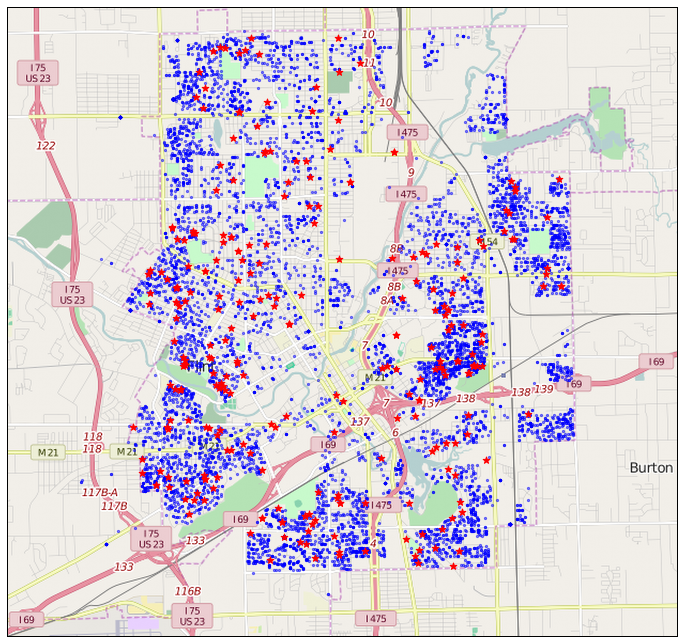

In [7]:
# Draw a map of lead readings.
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

lead_parcel_data = pd.read_csv('lead_parcel_data_train.csv')

safe_rows = lead_parcel_data['Lead (ppb)'] < 50
unsafe_rows = ~safe_rows

safe_lats = lead_parcel_data['Latitude'][safe_rows].values
safe_lons = lead_parcel_data['Longitude'][safe_rows].values

unsafe_lats = lead_parcel_data['Latitude'][unsafe_rows].values
unsafe_lons = lead_parcel_data['Longitude'][unsafe_rows].values

fig = plt.figure()
fig.set_size_inches(12,12)

m = Basemap(llcrnrlon=-83.77, llcrnrlat=42.97, urcrnrlon=-83.61, urcrnrlat=43.08,
            projection='lcc', lat_1=42, lat_2=44, lon_0=-83.65,
            resolution='i', area_thresh=100)

m.drawcoastlines()
m.drawstates()
m.drawcountries()

x, y = m(safe_lons, safe_lats)
m.scatter(x, y, 5, marker='o', color='b', alpha=0.5)

x,y = m(unsafe_lons, unsafe_lats)
m.scatter(x, y, 50, marker='*', color='r', alpha=1)

im = plt.imread('map.png')
m.imshow(im, interpolation='lanczos', origin='upper')
fig.savefig('lead_readings.png')